In [37]:
%matplotlib notebook
import hyperspy.api as hs
import numpy as np
import matplotlib.pylab as plt

## Create some test data
- 50x50 array of Gaussians with randomly varying A, mu, and sigma

<IPython.core.display.Javascript object>


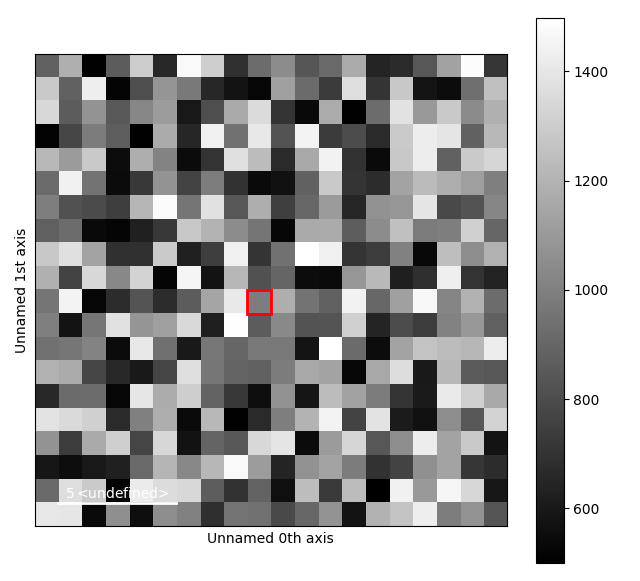

<IPython.core.display.Javascript object>


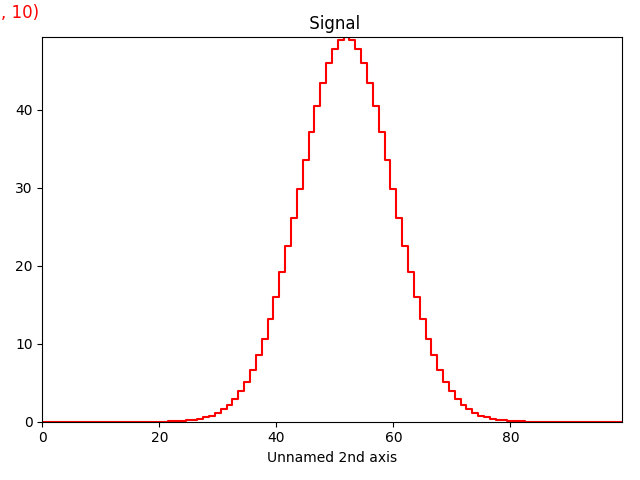

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [10]:
amps = hs.signals.Signal2D(np.random.randint(500,1500,size=[20,20]))
centers = hs.signals.Signal2D(np.random.randint(45,55,size=[20,20]))
sigmas = hs.signals.Signal2D(np.random.randint(5,10,size=[20,20]))

xaxis = np.tile(np.arange(0,100),20**2)
xaxis = xaxis.reshape([20,20,100])
xaxis = np.rollaxis(xaxis,2)
curves = amps.data/np.sqrt(2*np.pi*sigmas.data**2)*np.exp(-(xaxis-centers.data)**2/(2*sigmas.data**2))
curves = np.rollaxis(curves,0,3)
gaussians = hs.signals.Signal1D(curves)

gaussians.plot()

## Create a model
- Add single Gaussian component
- Perform fit at all pixel locations

In [11]:
gaussians_model = gaussians.create_model()
gaussians_model.append(hs.model.components1D.Gaussian())
gaussians_model[0].estimate_parameters(gaussians,10,90,False)
gaussians_model.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            Gaussian |            Gaussian |            Gaussian

<IPython.core.display.Javascript object>


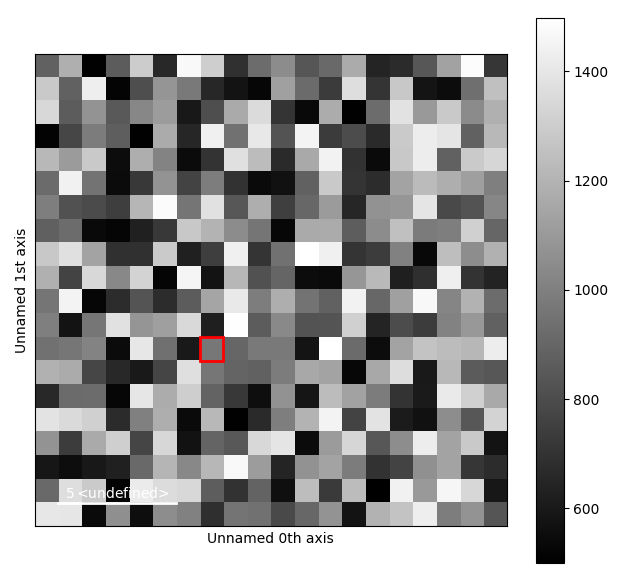

<IPython.core.display.Javascript object>


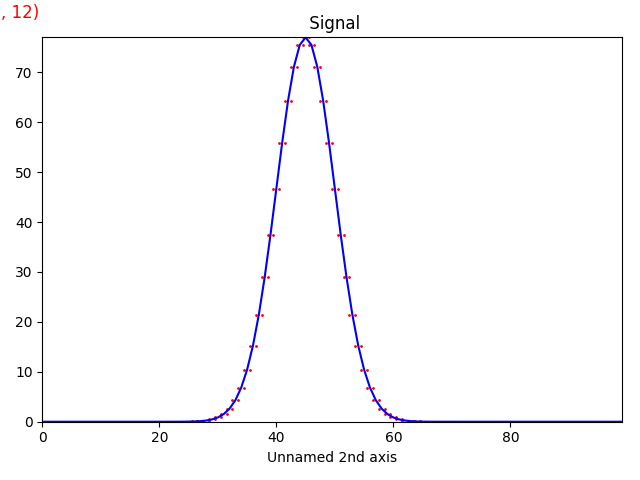

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [12]:
gaussians_model.multifit()
gaussians_model.plot()

## Compare fitted values to test data


<IPython.core.display.Javascript object>


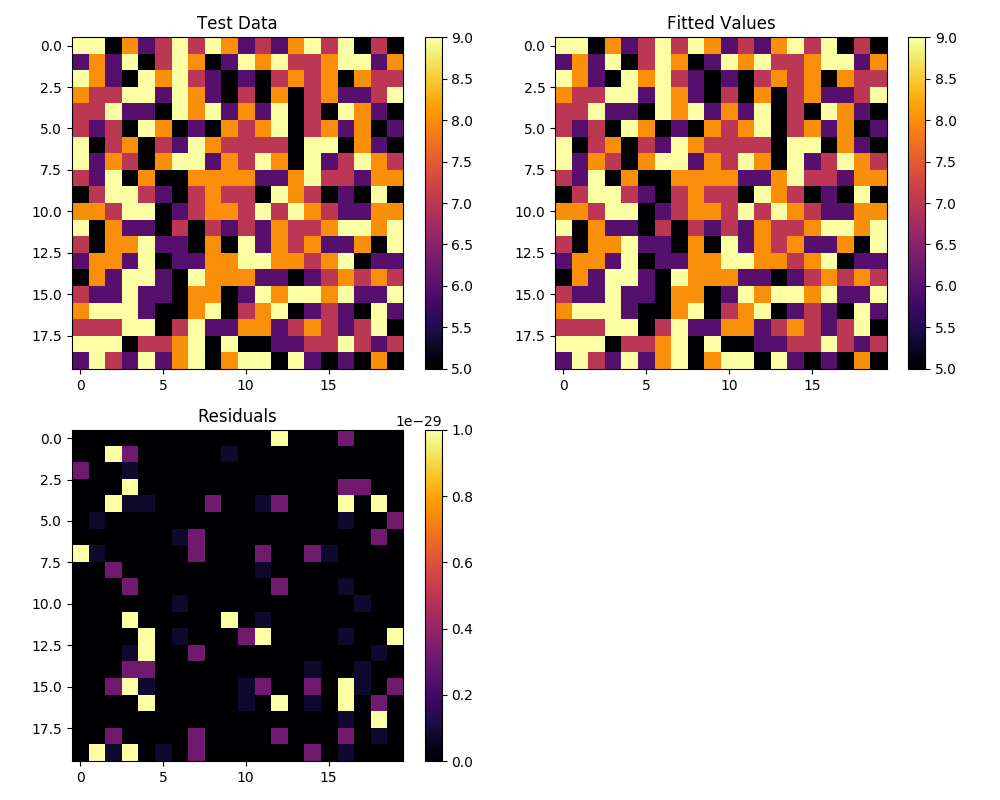

In [153]:
sig_results = gaussians_model.components.Gaussian.parameters[1].as_signal()
residuals = (sig_results-sigmas)**2

fig,axes = plt.subplots(2,2,figsize=(10,8))

sigmaplot = axes[0,0].imshow(sigmas.data,cmap='inferno',clim=[5,9])
axes[0,0].set_title('Test Data')
plt.colorbar(sigmaplot,ax=axes[0,0])

resultsplot = axes[0,1].imshow(sig_results.data,cmap='inferno',clim=[5,9])
axes[0,1].set_title('Fitted Values')
plt.colorbar(resultsplot,ax=axes[0,1])

residualsplot = axes[1,0].imshow(residuals,cmap='inferno',clim=[0,1e-29])
axes[1,0].set_title('Residuals')
plt.colorbar(residualsplot,ax=axes[1,0]) 
axes[1,1].axis('off')

plt.tight_layout()

## Add some noise to the test data

In [13]:
noisy = gaussians.deepcopy()
noisy.unfold()

for i in range(0,20**2):
    noisy.data[i,:] =noisy.data[i,:] + np.random.poisson(np.sqrt(noisy.data[i,:].max()),100)
noisy.fold()

## Create a model from the noisy data
- Add a single Gaussian component
- Add a lineaer offset to account for 'background' from adding noise
- Perform fit at all image pixels

100%|███████████████████████████████████████| 400/400 [00:02<00:00, 198.05it/s]


<IPython.core.display.Javascript object>


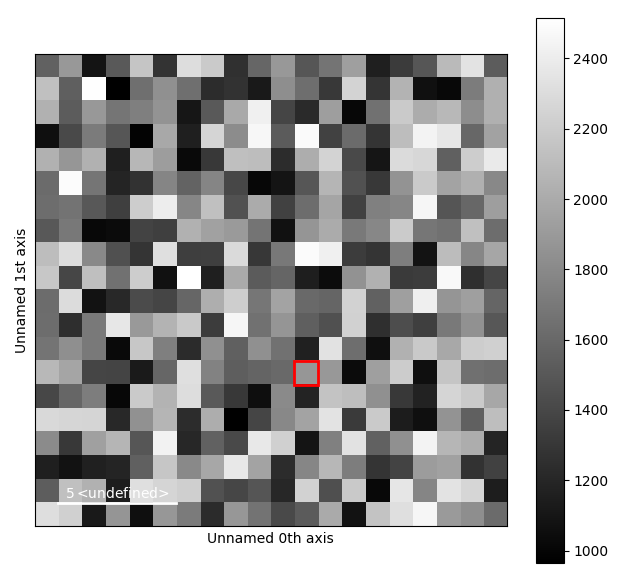

<IPython.core.display.Javascript object>


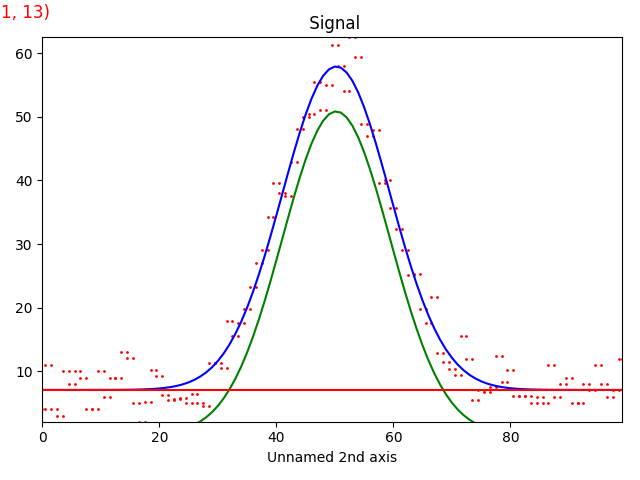

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [14]:
noisy_model = noisy.create_model()
noisy_model.append(hs.model.components1D.Gaussian())
noisy_model.append(hs.model.components1D.Offset())
noisy_model[0].estimate_parameters(noisy,10,90,False)
noisy_model[1].estimate_parameters(noisy,10,90,False)
noisy_model.multifit(show_progressbar=True)
noisy_model.plot(plot_components=True)

# More Realistic Application: Fitting EELS Fine Structure

## Useful aside: The EELS Database
<img src='EELSdb_logo-medium.png' width='500' align='center'/>

- https://eelsdb.eu/
    - Largest open-access repository of EELS and X-ray absorption spectra
    - Nearly 300 spectra covering 43 elements and growing
- Database can be directly queried by:
    - Title, ex. "Hexagonal Boron Nitride"
    - Formula, ex. "BN"
    - Elements, ex. "B,N"
    - Edge, ex. "K" or "L1"
    - Etc., many other options
- Spectra can be pulled directly from database without downloading

In [160]:
hs.datasets.eelsdb(formula='BN')

[<EELSSpectrum, title: Boron nitride, dimensions: (|1002)>,
 <EELSSpectrum, title: boron nitride, dimensions: (|837)>,
 <EELSSpectrum, title: Boron Nitride single wall nanotube, dimensions: (|1256)>,
 <EELSSpectrum, title: Boron Nitride multiwall nanotube, dimensions: (|786)>,
 <EELSSpectrum, title: Boron Nitride multiwall nanotube, dimensions: (|792)>,
 <EELSSpectrum, title: Boron Nitride single wall nanotube, dimensions: (|561)>,
 <EELSSpectrum, title: Boron Nitride triple wall nanotube, dimensions: (|546)>,
 <EELSSpectrum, title: Hexagonal Boron Nitride, dimensions: (|1024)>,
 <EELSSpectrum, title: Hexagonal Boron Nitride, dimensions: (|1024)>,
 <EELSSpectrum, title: Cubic boron nitride, dimensions: (|946)>,
 <EELSSpectrum, title: Cubic boron nitride, dimensions: (|812)>]

In [164]:
hs.datasets.eelsdb(element=('Fe','O'),spectrum_type='coreloss')

[<EELSSpectrum, title: Iron (III) oxide, hematite, dimensions: (|1024)>,
 <EELSSpectrum, title: Iron Oxide, dimensions: (|1024)>,
 <EELSSpectrum, title: Hematite, dimensions: (|1024)>,
 <EELSSpectrum, title: Iron Oxide Hematite, dimensions: (|926)>,
 <EELSSpectrum, title: Iron Oxide Hematite, dimensions: (|620)>,
 <EELSSpectrum, title: Ti-ferrite (spinel), dimensions: (|780)>,
 <EELSSpectrum, title: Ti-ferrite (spinel), dimensions: (|780)>,
 <EELSSpectrum, title: Iron Oxide Magnetite, dimensions: (|911)>,
 <EELSSpectrum, title: Iron Oxide Magnetite, dimensions: (|629)>,
 <EELSSpectrum, title: Iron Oxide Siderite, dimensions: (|826)>,
 <EELSSpectrum, title: Iron Oxide Siderite, dimensions: (|605)>,
 <EELSSpectrum, title: Iron Oxide 2-lines ferrihydrite, dimensions: (|671)>,
 <EELSSpectrum, title: Iron Oxide 2-lines ferrihydrite, dimensions: (|660)>,
 <EELSSpectrum, title: Iron Oxide Goethite, dimensions: (|1024)>,
 <EELSSpectrum, title: Iron Oxide Goethite, dimensions: (|704)>,
 <EELSSp

## Load data downloaded from EELS Database
- Core-loss and low-loss boron nitride spectra
- Set microscope parameters
- Add Boron and Nitrogen to model
- Create model
    - Automatically adds PowerLaw component to fit background
    - Automatically adds relevant edges in the energy range of the spectrum

In [184]:
s = hs.datasets.eelsdb(title="Hexagonal Boron Nitride", spectrum_type="coreloss")[0]
ll = hs.datasets.eelsdb(title="Hexagonal Boron Nitride", spectrum_type="lowloss")[0]

'''If no internet'''
#s = hs.load("BN_(hex)_B_K_Giovanni_Bertoni_100.msa")
#ll = hs.load("BN_(hex)_LowLoss_Giovanni_Bertoni_96.msa")

s.set_microscope_parameters(beam_energy=100, convergence_angle=0.2, collection_angle=2.55)
s.add_elements(('B', 'N'))

m = s.create_model(ll=ll)
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |                 N_K |                 N_K |          EELSCLEdge
   2 |                 B_K |                 B_K |          EELSCLEdge

<IPython.core.display.Javascript object>


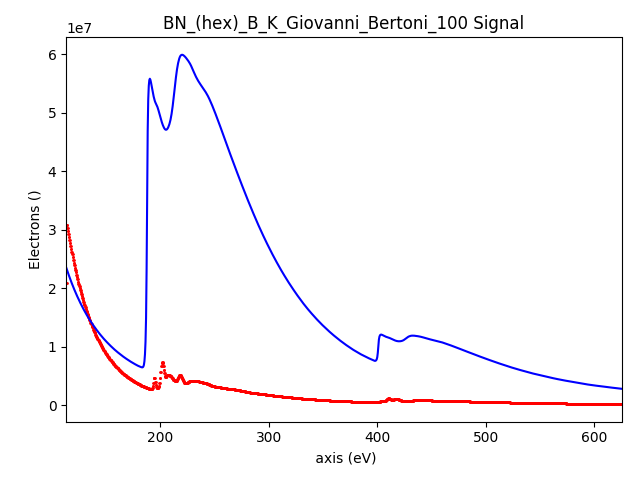

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [185]:
m.plot()

## Perform least squares fitting

<IPython.core.display.Javascript object>


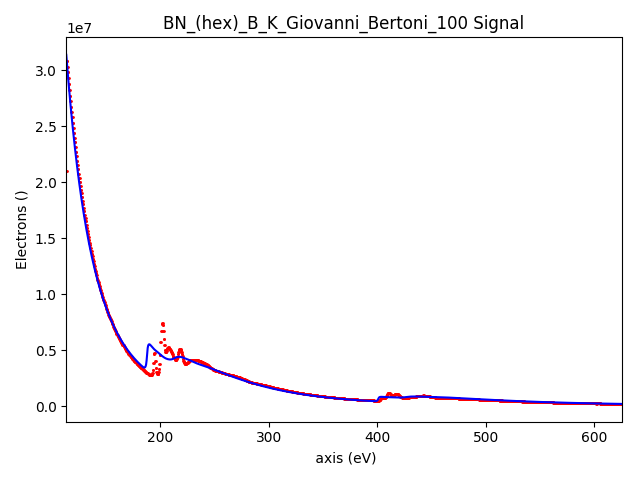

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [186]:
m.smart_fit()
m.plot()

## Perform least-squares fitting with fine structure
- Requires local database of ionization cross-sections
    - Comes with Digital Micrograph
    - Hydrogenic and Hartree-Slater models

<IPython.core.display.Javascript object>


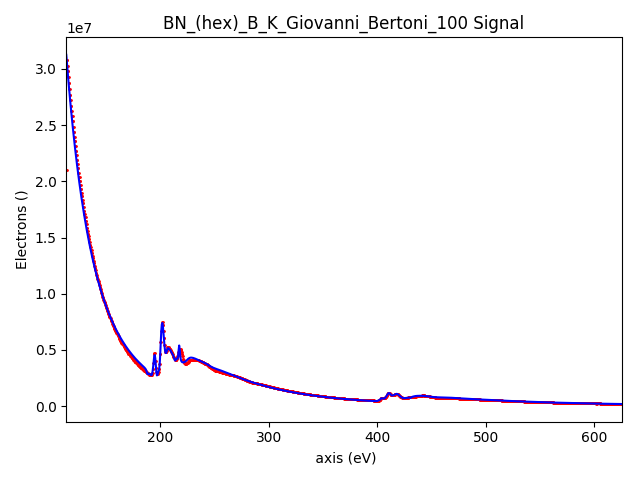

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [187]:
m.enable_fine_structure()
m.smart_fit()
m.plot()